# Load Dependencies


In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import os,gzip
from scipy import signal
import pandas as pd
from tqdm import tqdm

# Load Images

## **Define Model (Basic CNN)** ##

In [13]:
Image_shape=[1,5000,5000]
from cellpose import models
from skimage.color import label2rgb
import cv2
import numpy as np
import torch
import torch.nn as nn
import numpy as np
import io
from PIL import Image
from scipy import signal
import matplotlib.pyplot as plt
import celltypist
import scanpy as sc
import anndata as ad
from IPython.display import display, clear_output
import os
import mplcursors
# Define the CNN model
class ThresholdPredictorCNN(nn.Module):
            def __init__(self):
                super(ThresholdPredictorCNN, self).__init__()
                self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
                self.pool = nn.MaxPool2d(kernel_size=4, stride=4) ## Just to speed up, harsh pooling 
                self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
                self.conv3= nn.Conv2d(64,128,kernel_size=3,padding=1)
                self.fc1 = nn.Linear(128 * (Image_shape[1] // 64) * (Image_shape[2] // 64), 64)
                self.fc2 = nn.Linear(64, 1)


            def forward(self, x):
                x = self.pool(torch.relu(self.conv1(x)))
                x = self.pool(torch.relu(self.conv2(x)))
                x = self.pool(torch.relu(self.conv3(x)))
                x = x.view(-1, 128 * (Image_shape[1] // 64) * (Image_shape[2] // 64))
                x = torch.relu(self.fc1(x))
                x =  torch.div(0.5, (1+torch.exp(-self.fc2(x))))
                return x
model = ThresholdPredictorCNN()


In [4]:
class ThresholdLoss(nn.Module):
    def __init__(self):
        super(ThresholdLoss, self).__init__()
        
    def forward(self, y_true, y_pred):
        intersection = torch.sum(y_true * y_pred, dim=[1, 2, 3])
        union = torch.sum(y_true, dim=[1, 2, 3]) + torch.sum(y_pred, dim=[1, 2, 3]) - intersection
        iou = intersection / (union + 1e-6)
        loss = 1 - iou.mean()
        
        return loss

In [6]:
def combine_state_dict(file_path, num_chunks):
            try:
                combined_buffer = io.BytesIO()
                
                # Read each chunk file and write it to the combined buffer
                for i in range(1, num_chunks + 1):
                    chunk_file_path = f'{file_path}.part{i}'
                    with open(chunk_file_path, 'rb') as f:
                        chunk = f.read()
                        combined_buffer.write(chunk)
                        print(f"Read chunk {i} from {chunk_file_path}, size: {len(chunk)} bytes")
                
                combined_buffer.seek(0)

                # Deserialize the combined buffer back into a state dictionary
                state_dict = torch.load(combined_buffer)
                print("Model successfully reassembled from parts.")

                return state_dict

            except FileNotFoundError:
                print(f"One of the files not found: {file_path}")
            except Exception as e:
                print(f"An error occurred: {e}")




In [93]:
from PIL import Image
import gzip
import numpy as np
import matplotlib.patches as patches 
import matplotlib.pyplot as plt
import cv2
import os
import anndata as ad
def input_image(tif_image_path,npy_image_path,tif_scale_factor,npy_scale_factor,spatial_dataset=False):

    Image.MAX_IMAGE_PIXELS = None
    print('Loading Images')
    tif_image = Image.open(tif_image_path)
    tif_image_array = np.array(tif_image)  # Convert to NumPy array
    if spatial_dataset:
        print('Note: Adata objects typically takes longer to load')
        adata = ad.read_h5ad(npy_image_path)
        # Change array_row_bin to array_row according to data_struc
        array_row_bin = np.array(adata.obs.array_row_bin) 
        array_col_bin = np.array(adata.obs.array_col_bin)
        total=np.array(adata.X.sum(axis=1))
        reconstructed_matrix = np.zeros((1000,1000))
        for i in range(len(total)):
            reconstructed_matrix[array_row_bin[i],array_col_bin[i]]=total[i]
        npy_image_array=reconstructed_matrix
    else:
        with gzip.open(npy_image_path, 'rb') as f:
            npy_image_array = np.load(f)
        adata=None

    if npy_image_array.dtype != np.uint8:
        npy_image_array_normalized = (255 * (npy_image_array - np.min(npy_image_array)) / (np.max(npy_image_array) - np.min(npy_image_array))).astype(np.uint8)
    else:
        npy_image_array_normalized = npy_image_array
        
    x_factor=tif_image.size[0]/npy_image_array.shape[0]

    # Initialize dictionaries to store point coordinates for each image

    print('Compute Low-resolution')
    # Rescale the images for the initial low-res display
    tif_thumbnail = np.array(
        Image.fromarray(tif_image_array).resize(
            (int(tif_image_array.shape[1] * tif_scale_factor[0]),
            int(tif_image_array.shape[0] * tif_scale_factor[0])),
            resample=Image.LANCZOS
        )
    )
    print('--HnE Done')
    npy_thumbnail = np.array(
        Image.fromarray(npy_image_array_normalized).resize(
            (int(npy_image_array_normalized.shape[1] * npy_scale_factor[0]),
            int(npy_image_array_normalized.shape[0] * npy_scale_factor[0])),
            resample=Image.LANCZOS
        )
    )
    print('--Spatial Done')
    print('Compute high-resolution')

    tif_high_thumbnail = np.array(
        Image.fromarray(tif_image_array).resize(
            (int(tif_image_array.shape[1] * tif_scale_factor[1]),
            int(tif_image_array.shape[0] * tif_scale_factor[1])),
            resample=Image.LANCZOS
        )
    )
    print('--HnE Done')

    npy_high_thumbnail = np.array(
        Image.fromarray(npy_image_array_normalized).resize(
            (int(npy_image_array_normalized.shape[1] * npy_scale_factor[1]),
            int(npy_image_array_normalized.shape[0] * npy_scale_factor[1])),
            resample=Image.LANCZOS
        )
    )
    print('--Spatial Done')

    print('Compute HnE Grayscale')
    # Convert the HE image to grayscale
    #tif_thumbnail = tif_thumbnail[:, :, 0] * 0.5189 + tif_thumbnail[:, :, 1] * 0.1 + tif_thumbnail[:, :, 2] * 1
    tif_thumbnail = tif_thumbnail[:, :, 0] * 0.2989 + tif_thumbnail[:, :, 1] * 0.587 + tif_thumbnail[:, :, 2] * 0.114
    tif_high_thumbnail = tif_high_thumbnail[:, :, 0] * 0.2989 + tif_high_thumbnail[:, :, 1] * 0.587 + tif_high_thumbnail[:, :, 2] * 0.114
    #tif_high_thumbnail = tif_high_thumbnail[:, :, 0] * 0.5189 + tif_high_thumbnail[:, :, 1] * 0.1 + tif_high_thumbnail[:, :, 2] * 1
    print('Compute HnE Grayscale Done')
    return tif_thumbnail,tif_high_thumbnail,npy_thumbnail,npy_high_thumbnail,x_factor,adata
#regular spatial example
tif_image_path = '/media/home/ckuo/data_science_project/Brain_alignment_Proj/240806/1/1_Default_Extended.tif'
npy_image_path = '/media/home/ckuo/data_science_project/Brain_alignment_Proj/st_npy/QT-MB-240806-1-5G_mtx.npy.gz'
tif_thumbnail,tif_high_thumbnail,npy_thumbnail,npy_high_thumbnail,x_factor,adata=input_image(tif_image_path,npy_image_path,tif_scale_factor=[0.02,0.2],npy_scale_factor=[0.5,1])

Loading Images
Compute Low-resolution
--HnE Done
--Spatial Done
Compute high-resolution
--HnE Done
--Spatial Done
Compute HnE Grayscale
Compute HnE Grayscale Done


In [71]:

# Call the function with the file path
print('resizing image to fit CNN-model')

image = np.array(
    Image.fromarray(npy_thumbnail).resize(
        (int(Image_shape[2]),
        int(Image_shape[1])),
        resample=Image.LANCZOS
    )
)
kernel = np.outer(signal.windows.gaussian(100, 25),
            signal.windows.gaussian(100, 25))
convolv_matrix = signal.fftconvolve(image, kernel, mode='same')
convolv_matrix = convolv_matrix / convolv_matrix.max()
convolv_matrix[convolv_matrix<0]=0 # assign 0 to value smaller than 0
image=convolv_matrix
model=ThresholdPredictorCNN()
print('Load Model')
state_dict = combine_state_dict('/media/home/ckuo/Centrillion_Spatial/Alignment_9_28/Functions/CNN_IOU_Model.pth', 2)
model.load_state_dict(state_dict)

model.eval()


resizing image to fit CNN-model
Load Model
Read chunk 1 from /media/home/ckuo/Centrillion_Spatial/Alignment_9_28/Functions/CNN_IOU_Model.pth.part1, size: 104857600 bytes
Read chunk 2 from /media/home/ckuo/Centrillion_Spatial/Alignment_9_28/Functions/CNN_IOU_Model.pth.part2, size: 94877240 bytes
Model successfully reassembled from parts.


ThresholdPredictorCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=778752, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

# Use Model for prediction

Predicting mask threshold
Predicted output:[[0.09404677]]
Saving mask as mask.png


Text(0.5, 1.0, 'CNN_predicted Spatial Mask ')

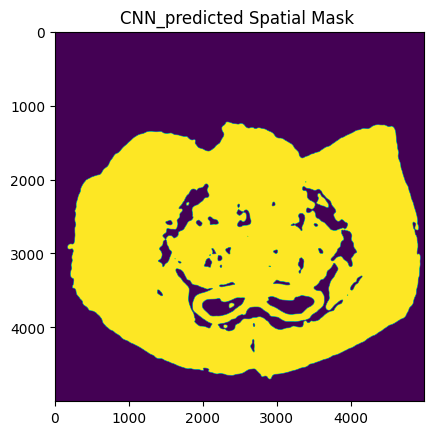

In [72]:
# Convert numpy array to torch tensor
image = torch.from_numpy(image).float()

# Move the tensor to the appropriate device
device = torch.device( "cpu")
image = image.to(device)

# Ensure your model is also on the same device
model = model.to(device)
print('Predicting mask threshold')
# Process each image independently
with torch.no_grad():  # Disable gradient calculation for inference
    single_image = image.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    output = np.array(model(single_image))
print('Predicted output:'+str(output))
mask=convolv_matrix>output

print('Saving mask as mask.png')
binary_mask_255 = (mask * 255).astype(np.uint8)  # Scale 0 and 1 to 0 and 255

# Convert to a PIL image
image = Image.fromarray(binary_mask_255)
# Save the image as a PNG
if not os.path.exists('output'):
    os.makedirs('output')
    print(f"Folder output created.")
image.save('output/mask.png')
plt.imshow(mask)
plt.title('CNN_predicted Spatial Mask ')


In [94]:
min_value = np.percentile(tif_high_thumbnail, 1)
max_value = 224
tif_tile_copy = (tif_high_thumbnail - min_value) / (max_value - min_value) * 255
tif_tile_copy = tif_tile_copy.astype(np.uint8)
inverted_image = cv2.bitwise_not(tif_tile_copy)
alpha = 2.0
beta = -100
enhanced_image = cv2.convertScaleAbs(inverted_image, alpha=alpha, beta=beta)
enhanced_image[tif_high_thumbnail > 230] = 0

image = np.array(
    Image.fromarray(enhanced_image).resize(
        (int(Image_shape[2]),
        int(Image_shape[1])),
        resample=Image.LANCZOS
    )
)
kernel = np.outer(signal.windows.gaussian(100, 25),
            signal.windows.gaussian(100, 25))
convolv_matrix = signal.fftconvolve(image, kernel, mode='same')
convolv_matrix = convolv_matrix / convolv_matrix.max()
convolv_matrix[convolv_matrix<0]=0 # assign 0 to value smaller than 0
image=convolv_matrix

Predicting mask threshold
Predicted output:[[0.15203463]]
Saving mask as mask.png


Text(0.5, 1.0, 'CNN_predicted HnE Mask ')

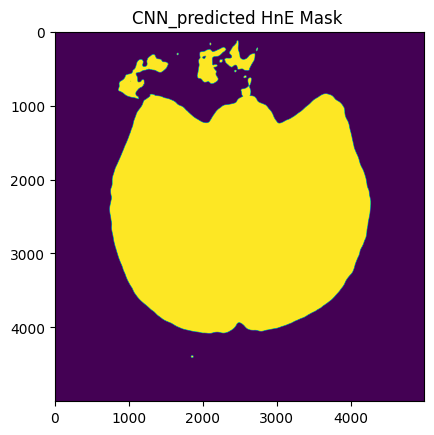

In [95]:

# Convert numpy array to torch tensor
image = torch.from_numpy(image).float()

# Move the tensor to the appropriate device
device = torch.device( "cpu")
image = image.to(device)

# Ensure your model is also on the same device
model = model.to(device)
print('Predicting mask threshold')
# Process each image independently
with torch.no_grad():  # Disable gradient calculation for inference
    single_image = image.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    output = np.array(model(single_image))
print('Predicted output:'+str(output))
mask=convolv_matrix>output

print('Saving mask as mask.png')
binary_mask_255 = (mask * 255).astype(np.uint8)  # Scale 0 and 1 to 0 and 255

# Convert to a PIL image
image = Image.fromarray(binary_mask_255)
# Save the image as a PNG
if not os.path.exists('output'):
    os.makedirs('output')
    print(f"Folder output created.")
image.save('output/mask.png')
plt.imshow(mask)
plt.title('CNN_predicted HnE Mask ')


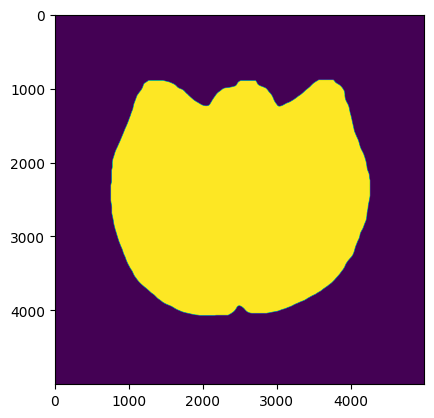

In [100]:
import cv2
kernel_size = 200  # Adjust this value to control the size of speckles to remove
kernel = np.ones((kernel_size, kernel_size), np.uint8)
mask_cleaned = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)
plt.imshow(mask_cleaned)

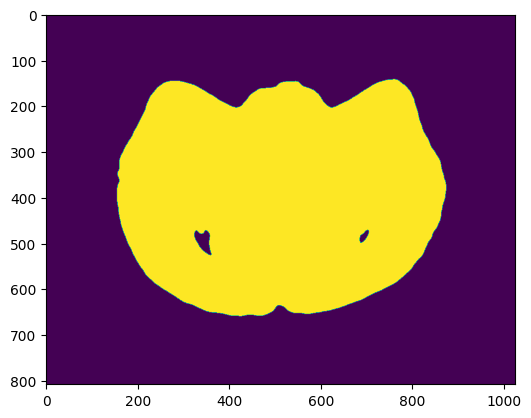

In [86]:
image = np.array(
    Image.fromarray(mask).resize(
        (int(tif_thumbnail.shape[1]),
        int(tif_thumbnail.shape[0])),
        resample=Image.LANCZOS
    )
)
plt.imshow(image)

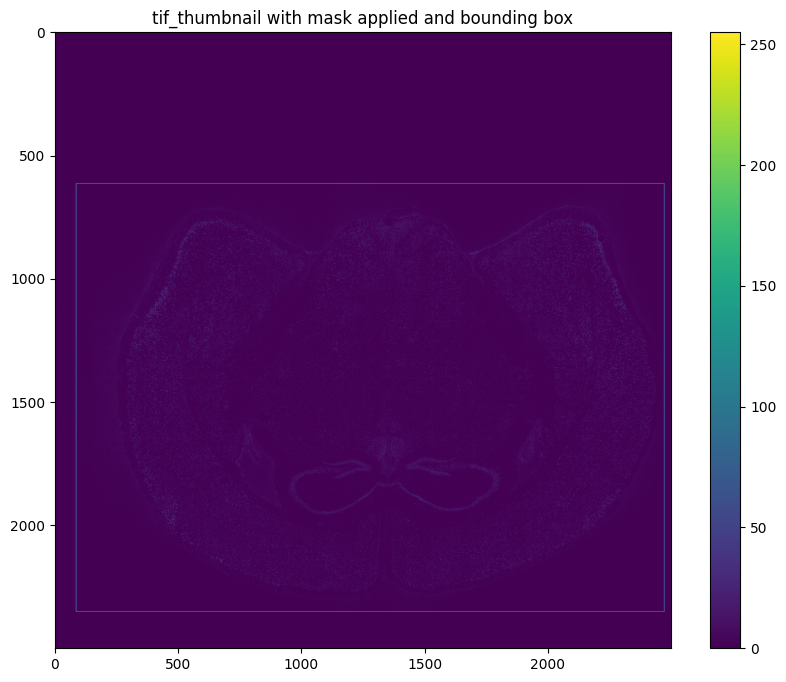

In [81]:
mask=image
rows = np.any(mask, axis=1)
cols = np.any(mask, axis=0)
y_min, y_max = np.where(rows)[0][[0, -1]]
x_min, x_max = np.where(cols)[0][[0, -1]]
width = x_max - x_min + 1
height = y_max - y_min + 1

# Create a copy of the masked thumbnail for drawing
display_image = npy_thumbnail.copy()

# Draw the rectangle
display_image[y_min:y_max+1, x_min] = 255  # Left edge
display_image[y_min:y_max+1, x_max] = 255  # Right edge
display_image[y_min, x_min:x_max+1] = 255  # Top edge
display_image[y_max, x_min:x_max+1] = 255  # Bottom edge

# Display the result
plt.figure(figsize=(10, 8))
plt.imshow(display_image, cmap='viridis')
plt.title('tif_thumbnail with mask applied and bounding box')
plt.colorbar()
plt.show()

